In [2]:
from orphics import io, maps, lensing, cosmology, stats
from pixell import enmap, curvedsky
import healpy as hp
import configparser
import numpy as np
import json
from ast import literal_eval
import tools
import matplotlib.pyplot as plt

In [3]:
# Simulate bias of lensing reconstruction from non-Gaussian kSZ

# Read in parameters from parameters.ini
config = configparser.ConfigParser()
config.read('parameters.ini')

# maps information
map_source = config['maps'].get('map_source')
ksz_type = config['maps'].get('ksz_type')
decmax = config['maps'].getint('decmax')
width_deg = int(config['maps']['width_deg'])

# experiments configurations
experiments = literal_eval(config['experiments'].get('experiments'))
# pixel size in arcmin
px_arcmin = config['experiments'].getfloat('px_arcmin')

# CMB ell range
ellmin = config['CMB'].getint('ellmin')
ellmaxs = json.loads(config['CMB'].get('ellmaxs'))

# Kappa L range
# delta_L = config['Kappa'].getint('delta_L')

# Use maps provided by websky or Colin
map_path = 'maps/' + map_source + '/'
# Path of output data
data_path = 'output/data/'

In [4]:
band_shape, band_wcs = enmap.band_geometry(dec_cut=np.deg2rad(decmax),
                                           res=np.deg2rad(px_arcmin / 60.))

band_modlmap = enmap.modlmap(band_shape, band_wcs)

In [5]:
cmb_alm = hp.read_alm(map_path + 'lensed_cmb_alm.fits', hdu=1)

In [6]:
cmb_band = curvedsky.alm2map(cmb_alm, enmap.empty(band_shape, band_wcs))

In [20]:
# calculate cmb_band powerspectrum on each realization
width_deg = 30
npix = int(width_deg * 60 / px_arcmin)
ntiles = int(np.prod(band_shape) / npix**2)
num_x = int(360 / width_deg)
delta_L = 150
Lmin, Lmax = 30, 3000

In [21]:
st = stats.Stats()
ix, iy = 0, 0
for itile in range(ntiles):
            # Get bottom-right pixel corner
            ex = ix + npix
            ey = iy + npix

            # Slice cmb_tg
            cmb = cmb_band[iy:ey, ix:ex]
            Ls, cmb_cl = tools.powspec(cmb, lmin=Lmin, lmax=Lmax, delta_l=delta_L)
            # Stride across the map, horizontally first and
            # increment vertically when at the end of a row

            if (itile + 1) % num_x != 0:
                ix = ix + npix
            else:
                ix = 0
                iy = iy + npix
            st.add_to_stats('cmb_cl', cmb_cl)

In [22]:
st.get_stats()

In [23]:
cmb_cl = st.stats['cmb_cl']['mean']
cmb_cl_err = st.stats['cmb_cl']['errmean']

In [24]:
input_cmb_cl = hp.alm2cl(cmb_alm)

[1.82522239e-02 2.98895909e-03 4.06998178e-04 2.01683587e-04
 1.03058375e-04 9.41678707e-05 3.90148171e-05 2.19000511e-05
 1.39078082e-05 1.15463849e-05 7.97918495e-06 2.17416842e-06
 2.35233605e-06 1.09813129e-06 8.51969597e-07 3.12114126e-07
 2.32321041e-07 1.47230144e-07 1.13237519e-07]
[1.68514623e+00 4.87105376e-01 8.03513714e-02 4.65376629e-02
 2.47867485e-02 1.81736035e-02 7.33704595e-03 5.04615553e-03
 2.85408894e-03 2.07347823e-03 1.11554760e-03 7.26662265e-04
 4.49277069e-04 3.08993160e-04 1.88387887e-04 1.20880055e-04
 7.82462816e-05 5.25717875e-05 3.40512507e-05]


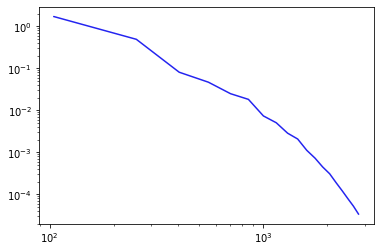

In [25]:
plt.errorbar(Ls, cmb_cl, yerr=cmb_cl_err)
plt.loglog()
print(cmb_cl_err)
print(cmb_cl)

<ErrorbarContainer object of 3 artists>

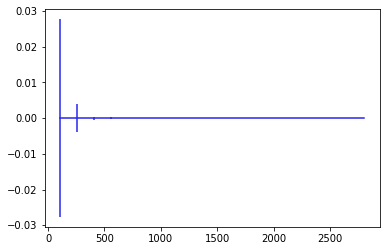

In [71]:
plt.errorbar(Ls, np.zeros(np.shape(Ls)), yerr=cmb_cl_err)

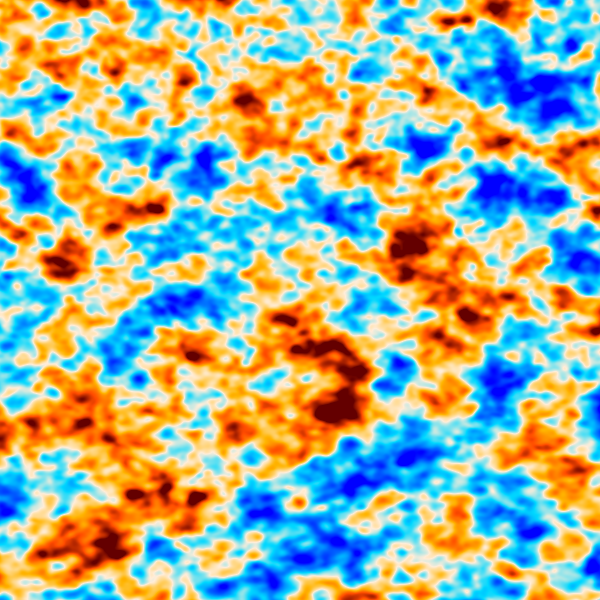

In [72]:
map_test = cmb_band[0:npix, 0:npix]
io.hplot(map_test)

In [ ]:
# test single cutout lensing reconstruction